**<center><h1>Speaker Classification with Deep Learning</h1></center>**
**<center><h2>Speech Technology Assignment 2023-24</h2></center>**
**<center><h3>Matthias Bartolo</h3></center>**

**<h3>1. Introduction</h3>**

<p>
<b>Speaker Identification (SID)</b>, is the task of determining a speaker's identity from a particular speech sample that has been chosen from a group of recognised speakers. Speech data from various speakers is gathered and used to train a model that represents the hypothetical speaker, or a model that learns to discriminate among speakers, in order to construct a SID system.
</p>

**<h3>2. Package Installation</h3>**

In [1]:
# !pip install librosa
# !pip install tensorflow
# !pip install keras
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install seaborn

**<h3>3. Package Imports</h3>**

In [2]:
import os
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns


warnings.filterwarnings('ignore')

# Declaring constants
# Sample rate is the number of samples of audio carried per second, measured in Hz or kHz (one kHz being 1000 Hz).
SAMPLE_RATE = 16000
# The number of melodies to extract from each audio chunk
N_MELS = 128
# The number of mel-spectrogram frames to extract from each audio chunk
MEL_SPEC_FRAME_SIZE = 1024
# The number of speakers/classes in the dataset
NUM_CLASSES = 285
# Mel-spectrogram flag
MEL_SPECTROGRAM = 1
# MFCC flag
MFCC = 0

**<h3>4. Loading and Filtering Dataset</h3>**

**<h4>Function to get the list of speaker roots in the data path</h4>**

In [3]:
def get_speaker_roots_in_data_path(datapath=os.path.join(os.getcwd(), 'ABI-1 Corpus\\accents')):
    """Function to get the list of speaker roots in the data path.
    
    Args:
        datapath (str): Path to the data folder.

    Returns:
        speaker_list (list): List of speaker roots in the data path.
    """
    # Declaring the list of speakers
    speaker_list = []

    # Retrieving the list of accent subfolders
    accent_subfolders = [f.path for f in os.scandir(datapath) if f.is_dir()]
    
    # Iterating through the accent subfolders
    for accent in accent_subfolders:
        # Iterating through the gender
        for gender in ['female', 'male']:
            # Retrieving the list of speaker folders
            speaker_folders = os.listdir(os.path.join(accent, gender))
            
            # Iterating through the speaker folders
            for speaker in speaker_folders:
                # Checking if the speaker folder is not a hidden folder
                if not speaker.startswith('.'):
                    speaker_list.append(os.path.join(accent, gender, speaker))
    
    # Returning the list of speakers
    return speaker_list

**<h4>Function to get the list of wav files in the data path</h4>**

In [4]:
def get_wav_files_in_path(datapath):
    """Function to get the list of wav files in the data path.

    Args:
        datapath (str): Path to the data folder.
    
    Returns:
        wav_files (list): List of wav files in the data path.
    """
    # Retrieving the list of files in the data path
    files = os.listdir(datapath)

    # Filtering the list of files to get only the wav files
    wav_files = [f for f in files if f.endswith('.wav')]

    # Appending the path to the wav files
    wav_files = [os.path.join(datapath, f) for f in wav_files]
    
    # Returning the list of wav files
    return wav_files

In [5]:
# Retrieving the list of speaker roots in the data path
speaker_roots = get_speaker_roots_in_data_path()
print('\033[1m' + 'Number of speakers found: ' + '\033[0m' + str(len(speaker_roots)))

# Retrieving the list of wav files in the data path
wav_files = []

# Iterating through the speaker roots
for speaker_root in speaker_roots:
    # Retrieving the list of wav files in the speaker root
    wav_files.extend(get_wav_files_in_path(speaker_root))

print('\033[1m' + 'Number of wav files found: ' + '\033[0m' + str(len(wav_files)))

# Setting the number of classes
NUM_CLASSES = len(speaker_roots)

Number of speakers found: 285
Number of wav files found: 2850


**<h3>5. Preprocessing Data, Chunking and Dataset Splitting</h3>**

**<h4>Function to display the spectrogram</h4>**

In [6]:
def display_spectrogram(spectrogram, sampling_rate=SAMPLE_RATE, hop_length=160, y_axis='linear', title='Linear Spectrogram'):
    """Function to display the spectrogram.
    
    Args:
        spectrogram (numpy.ndarray): Spectrogram to be displayed.
        sampling_rate (int): Sampling rate of the audio (default is 16000).
        hop_length (int): Hop length of the spectrogram (default is 160).
        y_axis (str): Type of y-axis to be displayed (default is linear).
        title (str): Title of the plot (default is Linear Spectrogram).
    """
    # Setting the figure size
    plt.figure(figsize=(20, 8))

    # Setting the title
    plt.xlabel('Time')

    # Setting the y-axis
    plt.ylabel('Mel-Frequency')
    
    # Displaying the spectrogram
    librosa.display.specshow(spectrogram,
                            y_axis=y_axis,
                            fmax=sampling_rate / 2,
                            sr=sampling_rate,
                            hop_length=hop_length,
                            x_axis='time')
    
    # Displaying the colorbar
    plt.colorbar(format='%+2.0f dB')
    
    # Displaying the title
    plt.title(title)
    
    # Displaying the plot
    plt.show()

**<h4>Function to chunk the audio file into specified-second segments</h4>**

In [7]:
def chunk_audio(audio_path, chunk_size=3, plot=False, feature_extractor=MEL_SPECTROGRAM):
    """Function to chunk the audio file into specified-second segments.
    
    Args:
        audio_path (str): Path to the audio file.
        chunk_size (int): Duration of each audio chunk in seconds (default is 3 seconds).
        plot (bool): Flag to plot the audio chunks (default is False).
        feature_extractor (int): Flag to indicate the feature extractor to be used (default is MEL_SPECTROGRAM).
    
    Returns:
        audio_chunks (list): List of audio chunks.
    """
    # Reading the audio file, whilst ensuring the sampling rate is 16kHz
    audio, sampling_rate = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Preprocessing the audio by normalizing the audio
    audio /= np.max(np.abs(audio), axis=0)
    
    # Calculating the number of samples per chunk
    samples_per_chunk = int(sampling_rate * chunk_size)
    
    # Calculating the number of chunks
    num_chunks = int(np.floor(len(audio) / samples_per_chunk))
    
    # Initializing the list of audio chunks
    audio_chunks = []
    
    # Iterating through the audio chunks
    for i in range(num_chunks):
        # Calculating the start and end sample
        start_sample = i * samples_per_chunk
        end_sample = (i + 1) * samples_per_chunk

        # Calculating the audio chunk
        audio_chunk = audio[start_sample:end_sample]

        if feature_extractor == MFCC:
            # Extracting the MFCCs using librosa
            mfcc = librosa.feature.mfcc(y=audio_chunk, 
                                        sr=sampling_rate,
                                        n_fft=MEL_SPEC_FRAME_SIZE,
                                        hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                        n_mfcc=N_MELS)

            # Setting the spectrogram to be the MFCCs
            spectrogram = mfcc
        else:
            # Extracting the mel spectrogram using librosa
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_chunk, 
                                                            sr=sampling_rate,
                                                            center=True,
                                                            n_fft=MEL_SPEC_FRAME_SIZE,
                                                            hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                                            n_mels=N_MELS)

            # Converting the raw amplitude results to decibels (log scale)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=1.0)

            # Setting the spectrogram to be the mel spectrogram
            spectrogram = mel_spectrogram

        # Plotting the spectrogram
        if plot:
            display_spectrogram(spectrogram, sampling_rate=sampling_rate, title='Mel Spectrogram of Audio Chunk ' + str(i + 1))

        # Appending the audio chunk to the list of audio chunks
        audio_chunks.append(spectrogram)
    
    # Returning the list of audio chunks
    return audio_chunks

**<h4>Function to preprocess, chunk and split the data</h4>**

In [8]:
def preprocess_data(speaker_roots, training_set_ratio, validation_set_ratio, testing_set_ratio, do_display=False, plot=False, feature_extractor=MEL_SPECTROGRAM):
    """"Function to preprocess, chunk and split the data.

    Args:
        speaker_roots (list): List of speaker roots in the data path.
        training_set_ratio (float): Ratio of the training set.
        validation_set_ratio (float): Ratio of the validation set.
        testing_set_ratio (float): Ratio of the testing set.
        do_display (bool): Boolean to display the audio chunks (default is False).
        plot (bool): Boolean to plot the spectrogram (default is False).
        feature_extractor (int): Flag to indicate the feature extractor to be used (default is MEL_SPECTROGRAM).

    Returns:
        training_set (list): List of training examples.
        validation_set (list): List of validation examples.
        testing_set (list): List of testing examples.
    """
    # Error checking for the ratios
    if training_set_ratio + validation_set_ratio + testing_set_ratio != 1:
        raise ValueError('The sum of the ratios must be equal to 1.')
    
    # Creating dictionary to store the speak to utterances mapping
    speaker_to_utterances = {}

    # Retrieving the list of speakers through the speaker roots, and giving each speaker a unique ID, since one of the speakers has the same name
    speakers ={speaker_root.split('\\')[-1]+str(unique_id): speaker_root for unique_id, speaker_root in enumerate(speaker_roots)}
  
    # Iterating through the speakers
    for speaker, speaker_root in speakers.items():
        if do_display:
            # Printing the speaker being processed
            print_message = '\033[32m' + 'Executing Speaker: ' + '\033[0m' + speaker + '\t {} / {}'.format(speaker_roots.index(speaker_root) + 1, len(speaker_roots))
            print(print_message)
            print('-' * len(print_message))

        # Retrieving the list of wav files in the speaker root
        speaker_wav_files = get_wav_files_in_path(speaker_root)
        
        # Initializing the list of utterances
        utterances = []
        
        # Iterating through the wav files
        for wav_file in speaker_wav_files:
            # Chunking the audio file into 3 seconds segments
            utterances.extend(chunk_audio(wav_file, plot=plot, feature_extractor=feature_extractor))
        
        # Appending the list of utterances to the dictionary
        speaker_to_utterances[speaker] = utterances

    # Calculating the total number of utterances
    total_num_utterances = sum([len(utterances) for utterances in speaker_to_utterances.values()])

    # Calculating the number of utterances for each set
    num_training_utterances = int(total_num_utterances * training_set_ratio)
    num_validation_utterances = int(total_num_utterances * validation_set_ratio)

    # Sorting the speakers by the number of utterances
    sorted_speakers = sorted(speaker_to_utterances.items(), key=lambda item: len(item[1]), reverse=True)

    # Initializing the relevant sets
    training_set = []
    validation_set = []
    testing_set = []

    # Declaring counter to keep track of the number of utterances
    train_num_utterances = 0
    val_num_utterances = 0
    test_num_utterances = 0

    # Assigning speakers to the training set
    while len(training_set) < num_training_utterances:
        # Retrieving the speaker and utterances
        speaker, utterances = sorted_speakers.pop(0)

        # Appending the utterances to the training set
        training_set.extend([(utterance, speaker) for utterance in utterances])

        # Updating the number of utterances in the training set
        train_num_utterances += len(utterances)
    
    # Assigning speakers to the validation set
    while len(validation_set) < num_validation_utterances:
        # Retrieving the speaker and utterances
        speaker, utterances = sorted_speakers.pop(0)

        # Appending the utterances to the validation set
        validation_set.extend([(utterance, speaker) for utterance in utterances])

        # Updating the number of utterances in the validation set
        val_num_utterances += len(utterances)

    # Assigning speakers to the testing set
    for speaker, utterances in sorted_speakers:
        # Appending all the remaining utterances to the testing set
        testing_set.extend([(utterance, speaker) for utterance in utterances])

        # Updating the number of utterances in the testing set
        test_num_utterances += len(utterances)

    # Shuffling the relevant sets
    random.shuffle(training_set)
    random.shuffle(validation_set)
    random.shuffle(testing_set)

    # Displaying the number of utterances in each set
    if do_display:
        print('\033[35m' + 'Percentage of utterances in each set:' + '\033[0m')
        print('\033[35m' + 'Training Set: ' + '\033[0m' + '{:.2%}'.format(train_num_utterances / total_num_utterances))
        print('\033[35m' + 'Validation Set: ' + '\033[0m' + '{:.2%}'.format(val_num_utterances / total_num_utterances))
        print('\033[35m' + 'Testing Set: ' + '\033[0m' + '{:.2%}'.format(test_num_utterances / total_num_utterances))
    
    # Returning the relevant sets
    return training_set, validation_set, testing_set

In [9]:
# Calling the preprocess_data function
training_set, validation_set, testing_set = preprocess_data(speaker_roots, 0.6, 0.2, 0.2, do_display=True, plot=False, feature_extractor=MEL_SPECTROGRAM)

Executing Speaker: alw0010	 1 / 285
--------------------------------------------
Executing Speaker: cxb0011	 2 / 285
--------------------------------------------
Executing Speaker: jah0012	 3 / 285
--------------------------------------------
Executing Speaker: jep0013	 4 / 285
--------------------------------------------
Executing Speaker: knb0014	 5 / 285
--------------------------------------------
Executing Speaker: lcg0015	 6 / 285
--------------------------------------------
Executing Speaker: lst0016	 7 / 285
--------------------------------------------
Executing Speaker: mjd0017	 8 / 285
--------------------------------------------
Executing Speaker: mpt0018	 9 / 285
--------------------------------------------
Executing Speaker: rkk0019	 10 / 285
---------------------------------------------
Executing Speaker: ajh00110	 11 / 285
----------------------------------------------
Executing Speaker: apd00111	 12 / 285
----------------------------------------------
Executing Speaker:

In [10]:
# Checking that the total number of unique labels in all sets is equal to the total number of speakers
# Extracting all unique y_train labels
y_train_labels = set(label for _, label in training_set)
print('\033[1m' + 'Number of unique labels in the training set: ' + '\033[0m' + str(len(y_train_labels)))

# Extracting all unique y_val labels
y_val_labels = set(label for _, label in validation_set)
print('\033[1m' + 'Number of unique labels in the validation set: ' + '\033[0m' + str(len(y_val_labels)))

# Extracting all unique y_test labels
y_test_labels = set(label for _, label in testing_set)
print('\033[1m' + 'Number of unique labels in the testing set: ' + '\033[0m' + str(len(y_test_labels)))

# Printing total number of unique labels
print('\033[1m' + 'Total number of unique labels: ' + '\033[0m' + str(len(y_train_labels | y_val_labels | y_test_labels)))

assert len(y_train_labels | y_val_labels | y_test_labels) == len(speaker_roots), "The total number of unique labels in all sets is not equal to the total number of speakers."
print('-'*97)
print('\033[32m' + 'Correct, The total number of unique labels in all sets is equal to the total number of speakers!' + '\033[0m')

Number of unique labels in the training set: 143
Number of unique labels in the validation set: 66
Number of unique labels in the testing set: 76
Total number of unique labels: 285
-------------------------------------------------------------------------------------------------
Correct, The total number of unique labels in all sets is equal to the total number of speakers!


In [11]:
# Preparing the training, validation and testing sets in the format required by the model, and converting them to numpy arrays
x_train = np.array([utterance for utterance, speaker in training_set])
y_train = np.array([speaker for utterance, speaker in training_set])

x_val = np.array([utterance for utterance, speaker in validation_set])
y_val = np.array([speaker for utterance, speaker in validation_set])

x_test = np.array([utterance for utterance, speaker in testing_set])
y_test = np.array([speaker for utterance, speaker in testing_set])

# One-hot encoding the labels
# Initializing the one-hot encoder
one_hot_encoder = OneHotEncoder(categories=[range(NUM_CLASSES)], handle_unknown='ignore')

# Reshaping the labels
y_train_encoded = y_train.reshape(-1, 1)
y_val_encoded = y_val.reshape(-1, 1)
y_test_encoded = y_test.reshape(-1, 1)

# Fitting the one-hot encoder on the training set and transforming the labels
y_train_encoded = one_hot_encoder.fit_transform(y_train_encoded).toarray()

# Using the fitted encoder to transform the validation and testing sets
y_val_encoded = one_hot_encoder.transform(y_val_encoded).toarray()
y_test_encoded = one_hot_encoder.transform(y_test_encoded).toarray()

# ----------------------------------------------------------------------------------------------

**<h3>6. Speaker Identification (SID) Model Design and Implementation</h3>**

In [12]:
# Defining the model
model = keras.Sequential()

# Input layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)))

# Hidden keras.layers
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Adding an LSTM layer
model.add(keras.layers.Reshape((30, 21*64)))  # Adjusted based on the output shape of the previous layer
model.add(keras.layers.LSTM(64, return_sequences=True))  # You can adjust the number of LSTM units as needed

# Flattening the output
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))  # Dropout layer for regularization
model.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

# Compiling the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 92, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 90, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 45, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 43, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 21, 64)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 30, 1344)          0

In [13]:
def plot_curves(history, metric, title, colors=['blue', 'cyan', 'green', 'purple'], marker='o', ylim=(0.7, 1.0)):
    """Function to plot the training and validation curves for the specified metric.
    
    Args:
        history (keras.callbacks.History): History of the model.
        metric (str): Metric to be plotted.
        title (str): Title of the plot.
        colors (list): List of colors for the training and validation curves (default is ['blue', 'cyan', 'green', 'purple']).
        marker (str): Marker for the best validation score (default is 'o').
        ylim (tuple): Limits for the y-axis (default is (0.7, 1.0)).
    """
    # Retrieving the metric values
    metric_train = history.history[metric]
    metric_val = history.history['val_' + metric]
    metric_loss = history.history['loss']
    metric_val_loss = history.history['val_loss']

    # Retrieving the number of epochs
    epochs = range(len(metric_train))

    # Plotting results
    plt.plot(epochs, metric_train, label='Training ' + metric.title(), color=colors[0], marker=marker)
    plt.plot(epochs, metric_val, label='Validation ' + metric.title(), color=colors[1], marker=marker)
    plt.plot(epochs, metric_loss, label='Training ' + 'Loss', color=colors[2], marker=marker)
    plt.plot(epochs, metric_val_loss, label='Validation ' + 'Loss', color=colors[3], marker=marker)
    plt.axvline(np.argmax(metric_val), linestyle='--', color='red', label='Best Val '+metric.title()+':' + str(round(np.max(metric_val), 2)))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss/'+metric.title())
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()

In [14]:
# Training the model
history = model.fit(x_train, y_train_encoded, batch_size=32, epochs=10, validation_data=(x_val, y_val_encoded))

# Saving the model
model.save('model.h5')

Epoch 1/10
  5/681 [..............................] - ETA: 3:11 - loss: 0.0000e+00 - accuracy: 0.0000e+00

KeyboardInterrupt: 

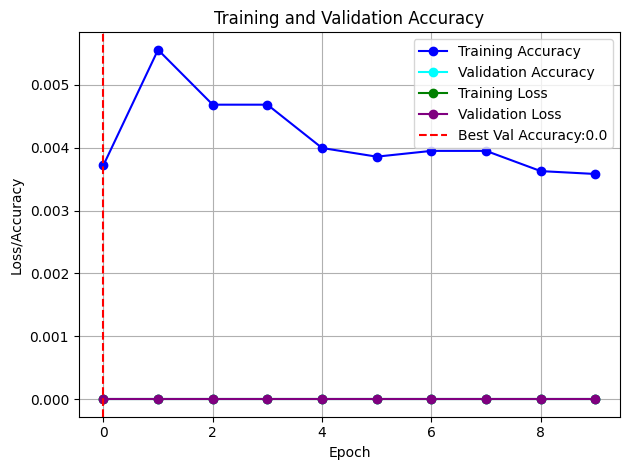

In [ ]:
# Plotting the training and validation loss and accuracy curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy')

**<h3>7. Evaluation</h3>**

In [ ]:
def display_confusion_matrix(confusion_matrix, title):
    """Function to display the confusion matrix.

    Args:
        confusion_matrix (numpy.ndarray): Confusion matrix to be displayed.
        title (str): Title of the plot.
    """
    # Setting the figure size
    plt.figure(figsize=(10, 7))

    # Saving data in a dataframe
    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ['Actual Positive', 'Actual Negative']],
                  columns = [i for i in ['Predicted Positive', 'Predicted Negative']])
    
    # Plotting the heatmap
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

    # Setting the title
    plt.title(title)

    # Displaying the plot
    plt.show()

In [ ]:
def display_metrics(y_true, y_pred, title):
    """Function to display the metrics.

    Args:
        y_true (numpy.ndarray): Ground truth labels.
        y_pred (numpy.ndarray): Predicted labels.
        title (str): Title of the plot.
    """
    # Calculating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculating the precision, recall and f1 score
    precision = precision_score(y_true, y_pred, pos_label=65)
    recall = recall_score(y_true, y_pred, pos_label=65)
    f1 = f1_score(y_true, y_pred, pos_label=65)

    # Displaying the metrics
    print('\033[1m' + 'Precision: ' + '\033[0m' + str(round(precision, 2)))
    print('\033[1m' + 'Recall: ' + '\033[0m' + str(round(recall, 2)))
    print('\033[1m' + 'F1 Score: ' + '\033[0m' + str(round(f1, 2)))

    # Displaying the confusion matrix
    display_confusion_matrix(cm, title)

In [ ]:
# Loading the model
model = keras.models.load_model('model.h5')

223/223 [==============================] - 13s 56ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Accuracy: 0.0
223/223 [==============================] - 12s 55ms/step
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


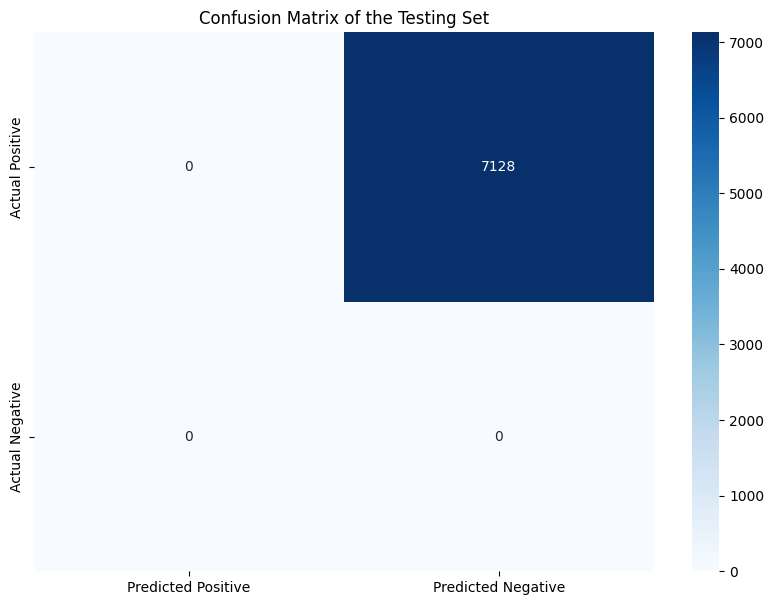

In [ ]:
# Evaluating the model on the testing set
test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded, verbose=1)

# Printing the test accuracy
print('\033[1m' + 'Test Accuracy: ' + '\033[0m' + str(test_accuracy))

# Predicting the labels of the testing set
y_pred = model.predict(x_test)

# Converting the predictions to labels
y_pred = np.argmax(y_pred, axis=1)

# Converting the one-hot encoded labels to labels
y_test = np.argmax(y_test_encoded, axis=1)

print()
print('\033[1m' + 'Metrics of the Testing Set' + '\033[0m')
# Displaying the metrics
display_metrics(y_test, y_pred, 'Confusion Matrix of the Testing Set')